# **Part 3**

In [1]:
import pandas as pd
import re
import numpy as np
import scipy
import itertools
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import KeyedVectors
from smart_open import open
from scipy.spatial.distance import cdist
from collections import Counter
from random import choice

# **Preprocessing**

In [2]:
#Storing the training and test datasets into their respective dataframes
trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Creating a function that takes care of all the preprocessing stuff.
def preprocess():

  trained['Tweet'] = trained['Tweet'].str.lower() # Ensuring all words in the Tweet column of training data are lowercased
  test['Tweet'] = test['Tweet'].str.lower() # Ensuring all words in the Tweet column of test data are lowercased

  # Parsing the stop_words.txt file and storing all the words in a list.
  stopwords = []
  with open('stop_words.txt','r') as file:    
      for line in file:         
          for word in line.split():            
              stopwords.append(word)

  # Removing all stopwords from all the tweets in training data.
  trained["Tweet"] = trained["Tweet"].apply(lambda func: ' '.join(sw 
                                            for sw in func.split() 
                                            if sw not in stopwords))

  # Removing all stopwords from all the tweets in test data.
  test["Tweet"] = test["Tweet"].apply(lambda func: ' '.join(sw 
                                            for sw in func.split() 
                                            if sw not in stopwords))

  special_chars = ["!",'"',"%","&","amp","'","(",")", "*","+",",","-",".",
                  "/",":",";","<","=",">","?","[","\\","]","^","_",
                  "`","{","|","}","~","–","@","#","$"]

  #Training Data
  trained['Tweet'] = trained['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets
  trained['Tweet'] = trained['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
  trained['Tweet'] = trained['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets
  trained['Tweet'] = trained['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets

  for c in special_chars:
      trained['Tweet'] = trained['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

  #Test Data
  test['Tweet'] = test['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets
  test['Tweet'] = test['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
  test['Tweet'] = test['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets
  test['Tweet'] = test['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets

  for c in special_chars:
      test['Tweet'] = test['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

  #Training Data
  train_unique = (list(set(trained['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in training data's Tweet column
  train_unique_words = len(train_unique)

  #Test Data
  test_unique = (list(set(test['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in test data's Tweet column
  test_unique_words = len(test_unique)

  # Making an empty column in our test data for predicted labels.
  test['Predicted Label'] = ''

  print("Unique words in Training Data: {}".format(train_unique_words))
  print("Unique words in Test Data: {}".format(test_unique_words))

In [3]:
preprocess()

Unique words in Training Data: 10033
Unique words in Test Data: 4839


In [4]:
trained.head()

,Sentiment,Tweet
0,neutral,amsterdam ewr
1,negative,itproblems link
2,positive,today staff msp took customer service new le...
3,negative,yet receive assistance one agents securing ne...
4,negative,let change reservation online wasting time


In [5]:
test.head()

,Sentiment,Tweet,Predicted Label
0,neutral,jump dallasaustin market news,
1,positive,chicago seen seat a aa far great ride pdx,
2,negative,need bag bouncer get together,
3,negative,hey jetblue stranded entire plane supposed go...,
4,negative,big fail curbside baggage pittsburgh charge ...,


In [6]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-10-16 14:58:15--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.92.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.92.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  89.6MB/s    in 17s     

2020-10-16 14:58:33 (91.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [7]:
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# **Repeating Part 1 with Word2Vec**

In [8]:
def extract_features(sentence):
  words = [word for word in sentence.split() if word in word2vec.vocab]
  if words == []:
    return []
  else:
    return np.mean(word2vec[words],axis=0)

In [9]:
train_embeddings = []

for sentence in trained['Tweet']:
  words = extract_features(sentence)
  if words == []:
    trained = trained.drop(trained[trained.Tweet == sentence].index)
  else:  
    train_embeddings.append(words)

trained = trained.reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [10]:
test_embeddings = []

for sentence in test['Tweet']:
  words = extract_features(sentence)
  if words == []:
    test = test.drop(test[test.Tweet == sentence].index)
  else:  
    test_embeddings.append(words)

test = test.reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [11]:
print("Shape of Training Matrix: ({0} , {1})".format(len(train_embeddings),len(train_embeddings[0])))
print("Shape of Test Matrix: ({0} , {1})".format(len(test_embeddings),len(test_embeddings[0])))

Shape of Training Matrix: (11672 , 300)
Shape of Test Matrix: (2916 , 300)


In [12]:
#Calculating distances between every test instance with all the train instances. This returns a 2D distances vector.
dists = cdist(test_embeddings,train_embeddings,'euclidean') 

In [13]:
# Making a general structure of our confusion matrix
cmatrix = pd.DataFrame({'Gold Positive': '', 'Gold Neutral': '', 'Gold Negative': ''},
                       index = ['Predicted Positive','Predicted Neutral','Predicted Negative'])

# Lists that will later store respective values for plotting
accuracy_list = []
recall_list = []
precision_list = []
F1_list = []

In [14]:
#Function that takes a list and returns the mode of the list. If there are more than one modes, it randomly selects any of them.
def get_mode(l):
    counting = Counter(l)
    max_count = max(counting.values())
    return choice([ks for ks in counting if counting[ks] == max_count])

In [15]:
def cmatrix_measures(k,dists,test,cmatrix):

  row_count = 0
  first_max = 0
  second_max = 0
  check_tie = False

  for ls in dists:
    sorted_distances_indices = np.argsort(ls) #Getting a sorted list of indices of all distances in ls with the smallest distance's index at 0th position
    knn_indices = []
    knn_indices = list(itertools.islice(sorted_distances_indices,k)) #Extracting the indices of the k-smallest distances

    knn_labels = []
    for i in knn_indices:
      label = trained['Sentiment'][i] #Extracting the label of the instance by indexing it through the DataFrame.
      knn_labels.append(label) #Appending the label to our labels list.

    max_class = get_mode(knn_labels)
    first_max = max_class
    second_max = max(knn_labels)
    if first_max == second_max:
      check_tie = True
    predicted_label = max_class
    test['Predicted Label'][row_count] = predicted_label

    row_count += 1

  #Creating a frequency DataFrame that will store value counts for each tuple of instances. E.g (positive,positive = 309) and so on for all other seven instances.
  testfreqdf = test.groupby(["Sentiment", "Predicted Label"]).size().reset_index(name="Frequency")
  testfreqdf

  #Extracting values from the Frequency DataFrame and assigning to specific cells in the confusion matrix.
  cmatrix['Gold Positive']['Predicted Positive'] = testfreqdf['Frequency'][8]
  cmatrix['Gold Neutral']['Predicted Positive'] = testfreqdf['Frequency'][5]
  cmatrix['Gold Negative']['Predicted Positive'] = testfreqdf['Frequency'][2]
  cmatrix['Gold Positive']['Predicted Neutral'] = testfreqdf['Frequency'][7]
  cmatrix['Gold Neutral']['Predicted Neutral'] = testfreqdf['Frequency'][4]
  cmatrix['Gold Negative']['Predicted Neutral'] = testfreqdf['Frequency'][1]
  cmatrix['Gold Positive']['Predicted Negative'] = testfreqdf['Frequency'][6]
  cmatrix['Gold Neutral']['Predicted Negative'] = testfreqdf['Frequency'][3]
  cmatrix['Gold Negative']['Predicted Negative'] = testfreqdf['Frequency'][0]

  #Extracting all three True Positives from the matrix to measure accuracy.
  TP = cmatrix['Gold Positive']['Predicted Positive']
  TNT = cmatrix['Gold Neutral']['Predicted Neutral']
  TN = cmatrix['Gold Negative']['Predicted Negative']
  total = testfreqdf['Frequency'].sum()
  accuracy = ((TP+TNT+TN)/total)*100
  accuracy = round(accuracy,2)
  accuracy_list.append(accuracy)

  recall_pos = cmatrix['Gold Positive']['Predicted Positive']/cmatrix['Gold Positive'].sum()
  recall_neut = cmatrix['Gold Neutral']['Predicted Neutral']/cmatrix['Gold Neutral'].sum()
  recall_neg = cmatrix['Gold Negative']['Predicted Negative']/cmatrix['Gold Negative'].sum()
  macroaveraged_recall = ((recall_pos+recall_neut+recall_neg)/3)*100
  macroaveraged_recall = round(macroaveraged_recall,2)
  recall_list.append(macroaveraged_recall)

  precision_pos = cmatrix['Gold Positive']['Predicted Positive']/(cmatrix.iloc[0,0:3].sum())
  precision_neut = cmatrix['Gold Neutral']['Predicted Neutral']/(cmatrix.iloc[1,0:3].sum())
  precision_neg = cmatrix['Gold Negative']['Predicted Negative']/(cmatrix.iloc[2,0:3].sum())
  macroaveraged_precision = ((precision_pos+precision_neut+precision_neg)/3)*100
  macroaveraged_precision = round(macroaveraged_precision,2)
  precision_list.append(macroaveraged_precision)

  F1_pos = (2*precision_pos*recall_pos)/(precision_pos+recall_pos)
  F1_neut = (2*precision_neut*recall_neut)/(precision_neut+recall_neut)
  F1_neg = (2*precision_neg*recall_neg)/(precision_neg+recall_neg)
  F1_score = ((F1_pos + F1_neut + F1_neg)/3)*100  
  F1_score = round(F1_score,2)
  F1_list.append(F1_score)
  

  print("\n\nConfusion Matrix with k = {}:\n".format(k))
  print(cmatrix)
  print("\nAccuracy with k = {0}: {1}%".format(k,accuracy))
  print("Macroaveraged Precision with k = {0}: {1}%".format(k,macroaveraged_precision))
  print("Macroaveraged Recall with k = {0}: {1}%".format(k,macroaveraged_recall))
  print("Macroaveraged F1-score with k = {0}: {1}%\n".format(k,F1_score))

In [16]:
cmatrix_measures(1,dists,test,cmatrix)
cmatrix_measures(3,dists,test,cmatrix)
cmatrix_measures(5,dists,test,cmatrix)
cmatrix_measures(7,dists,test,cmatrix)
cmatrix_measures(10,dists,test,cmatrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Confusion Matrix with k = 1:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           240           80           115
Predicted Neutral             71          236           174
Predicted Negative           161          295          1544

Accuracy with k = 1: 69.27%
Macroaveraged Precision with k = 1: 60.48%
Macroaveraged Recall with k = 1: 57.9%
Macroaveraged F1-score with k = 1: 58.9%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Confusion Matrix with k = 3:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           254           66            56
Predicted Neutral             47          182            86
Predicted Negative           171          363          1691

Accuracy with k = 3: 72.94%
Macroaveraged Precision with k = 3: 67.11%
Macroaveraged Recall with k = 3: 58.62%
Macroaveraged F1-score with k = 3: 60.85%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Confusion Matrix with k = 5:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           255           56            29
Predicted Neutral             35          154            51
Predicted Negative           182          401          1753

Accuracy with k = 5: 74.14%
Macroaveraged Precision with k = 5: 71.4%
Macroaveraged Recall with k = 5: 58.29%
Macroaveraged F1-score with k = 5: 61.03%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Confusion Matrix with k = 7:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           246           50            23
Predicted Neutral             28          136            32
Predicted Negative           198          425          1778

Accuracy with k = 7: 74.07%
Macroaveraged Precision with k = 7: 73.52%
Macroaveraged Recall with k = 7: 57.13%
Macroaveraged F1-score with k = 7: 59.96%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Confusion Matrix with k = 10:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           232           44            13
Predicted Neutral             27          119            25
Predicted Negative           213          448          1795

Accuracy with k = 10: 73.59%
Macroaveraged Precision with k = 10: 74.32%
Macroaveraged Recall with k = 10: 55.52%
Macroaveraged F1-score with k = 10: 58.37%



# **Plotting Part 1 Results with Word2Vec**

<function matplotlib.pyplot.show>

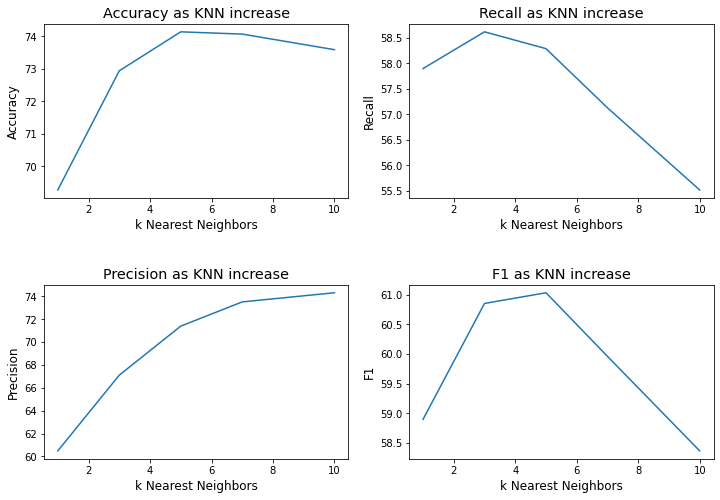

In [17]:
k_list = [1,3,5,7,10] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_list,accuracy_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_list,recall_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_list,precision_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_list,F1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show

#**Repeating Part 2 with Word2Vec**

In [18]:
# Storing the training and test datasets into their respective dataframes

trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# **Preprocessing**

In [19]:
#Storing the training and test datasets into their respective dataframes
trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
preprocess()

Unique words in Training Data: 10033
Unique words in Test Data: 4839


In [20]:
def extract_features(sentence):
  words = [word for word in sentence.split() if word in word2vec.vocab]
  if words == []:
    return []
  else:
    return np.mean(word2vec[words],axis=0)

In [21]:
train_embeddings = []

for sentence in trained['Tweet']:
  words = extract_features(sentence)
  if words == []:
    trained = trained.drop(trained[trained.Tweet == sentence].index)
  else:  
    train_embeddings.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [22]:
test_embeddings = []

for sentence in test['Tweet']:
  words = extract_features(sentence)
  if words == []:
    test = test.drop(test[test.Tweet == sentence].index)
  else:  
    test_embeddings.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
acc_list = []
rec_list = []
prec_list = []
f1_list = []

In [25]:
def classifying(trainfeatures,testfeatures):

  X_train = trainfeatures 
  X_test = testfeatures
  y_train = trained.iloc[:,0].values
  y_test = test.iloc[:,0].values

  for k in [1,3,5,7,10]:

    classifier = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    classifier.fit(X_train, y_train)
    predicted_label = classifier.predict(X_test)

    accuracy_score = (metrics.accuracy_score(y_test,predicted_label))
    accuracy_score = (round(accuracy_score,2))*100
    acc_list.append(accuracy_score)

    cmatrix = confusion_matrix(y_test, predicted_label)
    creport = classification_report(y_test, predicted_label)

    macro_precision = (metrics.precision_score(y_test, predicted_label, average='macro'))
    macro_precision = (round(macro_precision,2))*100
    prec_list.append(macro_precision)

    macro_recall = (metrics.recall_score(y_test, predicted_label, average='macro'))
    macro_recall = (round(macro_recall,2))*100
    rec_list.append(macro_recall)
    
    macro_f1 = (metrics.f1_score(y_test, predicted_label, average='macro'))
    macro_f1 = (round(macro_f1,2))*100
    f1_list.append(macro_f1)

    print("\n\nConfusion Matrix for k = {} is:\n".format(k))
    print(cmatrix)
    print("\nClassification Report for k = {} is:\n".format(k))
    print(creport)
    print("Accuracy Score for k = {0} is: {1}%".format(k,accuracy_score))
    print("Macroaveraged Recall for k = {0} is: {1}%".format(k,macro_recall))
    print("Macroaveraged Precision for k = {0} is: {1}%".format(k,macro_precision))
    print("Macroaveraged F1-score for k = {0} is: {1}%".format(k,macro_f1))

In [26]:
classifying(train_embeddings,test_embeddings)



Confusion Matrix for k = 1 is:

[[1540  175  118]
 [ 296  235   80]
 [ 161   78  233]]

Classification Report for k = 1 is:

              precision    recall  f1-score   support

    negative       0.77      0.84      0.80      1833
     neutral       0.48      0.38      0.43       611
    positive       0.54      0.49      0.52       472

    accuracy                           0.69      2916
   macro avg       0.60      0.57      0.58      2916
weighted avg       0.67      0.69      0.68      2916

Accuracy Score for k = 1 is: 69.0%
Macroaveraged Recall for k = 1 is: 56.99999999999999%
Macroaveraged Precision for k = 1 is: 60.0%
Macroaveraged F1-score for k = 1 is: 57.99999999999999%


Confusion Matrix for k = 3 is:

[[1714   74   45]
 [ 383  171   57]
 [ 201   34  237]]

Classification Report for k = 3 is:

              precision    recall  f1-score   support

    negative       0.75      0.94      0.83      1833
     neutral       0.61      0.28      0.38       611
    positive 

# **Plotting Part 2 Results with Word2Vec**

<function matplotlib.pyplot.show>

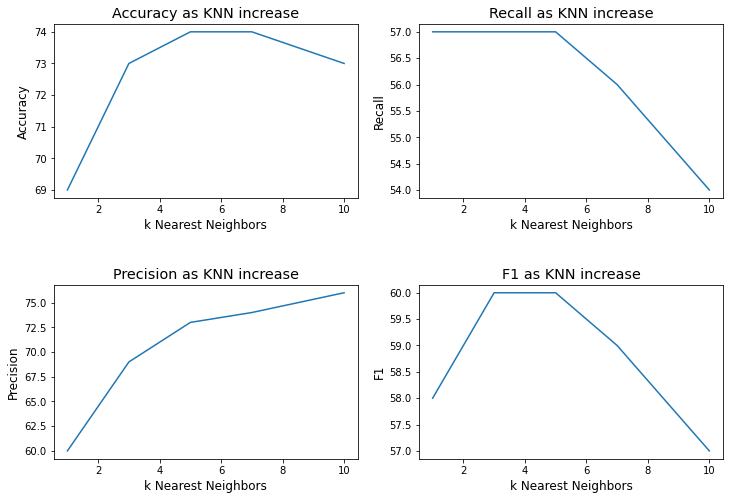

In [27]:
k_ls = [1,3,5,7,10] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_ls,acc_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_ls,rec_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_ls,prec_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_ls,f1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show